/bin/bash: /home/sjim/anaconda3/envs/Jim1/lib/libtinfo.so.6: no version information available (required by /bin/bash)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating dataset...
Dataset generated in 1.02 seconds.
Loading Phi-3 with LoRA...


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


trainable params: 1,572,864 || all params: 3,822,652,416 || trainable%: 0.0411
Model loaded in 4.46 seconds.
Fine-tuning (LoRA)...


/home/sjim/anaconda3/envs/Jim1/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/sjim/anaconda3/envs/Jim1/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Fine-tuning Epoch 1/30 — Avg Loss: 0.449152
Fine-tuning Epoch 2/30 — Avg Loss: 0.220988
Fine-tuning Epoch 3/30 — Avg Loss: 0.186926
Fine-tuning Epoch 4/30 — Avg Loss: 0.182275
Fine-tuning Epoch 5/30 — Avg Loss: 0.180505
Fine-tuning Epoch 6/30 — Avg Loss: 0.179435
Fine-tuning Epoch 7/30 — Avg Loss: 0.178973
Fine-tuning Epoch 8/30 — Avg Loss: 0.180372
Fine-tuning Epoch 9/30 — Avg Loss: 0.177852
Fine-tuning Epoch 10/30 — Avg Loss: 0.177188
Fine-tuning Epoch 11/30 — Avg Loss: 0.176111
Fine-tuning Epoch 12/30 — Avg Loss: 0.175590
Fine-tuning Epoch 13/30 — Avg Loss: 0.174708
Fine-tuning Epoch 14/30 — Avg Loss: 0.174056
Fine-tuning Epoch 15/30 — Avg Loss: 0.174684
Fine-tuning Epoch 16/30 — Avg Loss: 0.173904
Fine-tuning Epoch 17/30 — Avg Loss: 0.172110
Fine-tuning Epoch 18/30 — Avg Loss: 0.171424
Fine-tuning Epoch 19/30 — Avg Loss: 0.170807
Fine-tuning Epoch 20/30 — Avg Loss: 0.169609
Fine-tuning Epoch 21/30 — Avg Loss: 0.168758
Fine-tuning Epoch 22/30 — Avg Loss: 0.167451
Fine-tuning Epoch 2

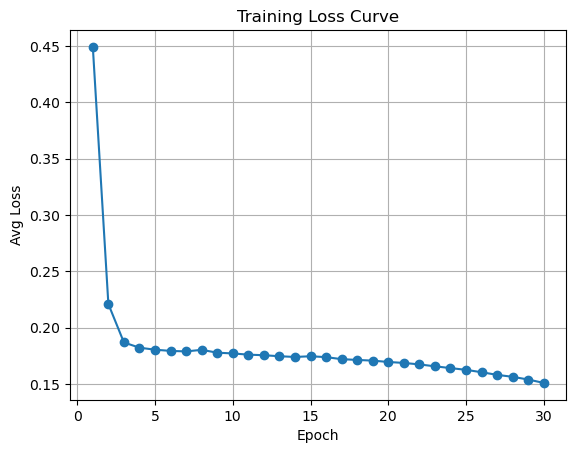

Fine-tuning completed in 7101.20 seconds.
Testing...


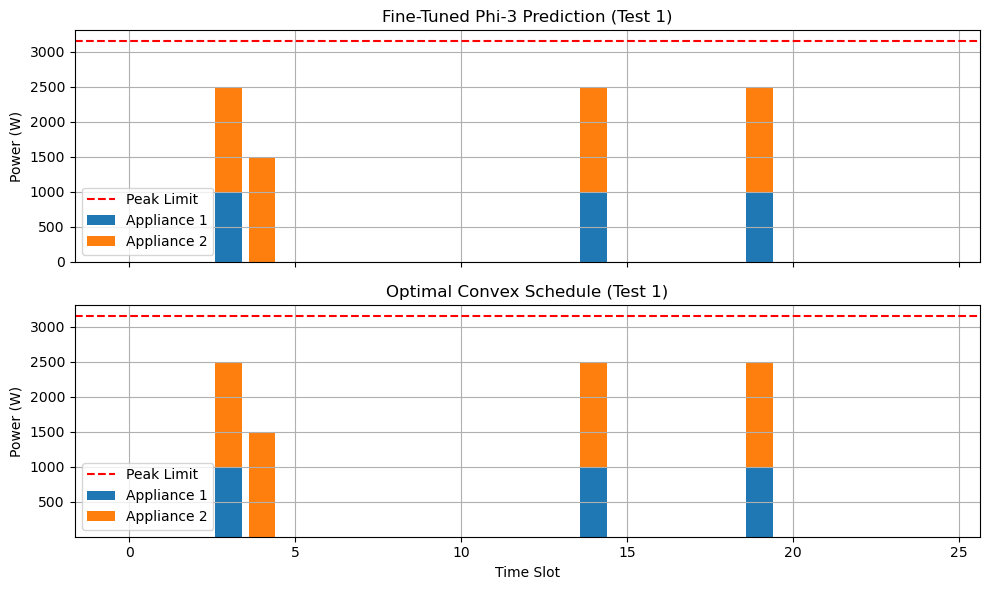

Test 1: Predicted Cost = $0.51 | Optimal Cost = $0.51 | Gap = $-0.00


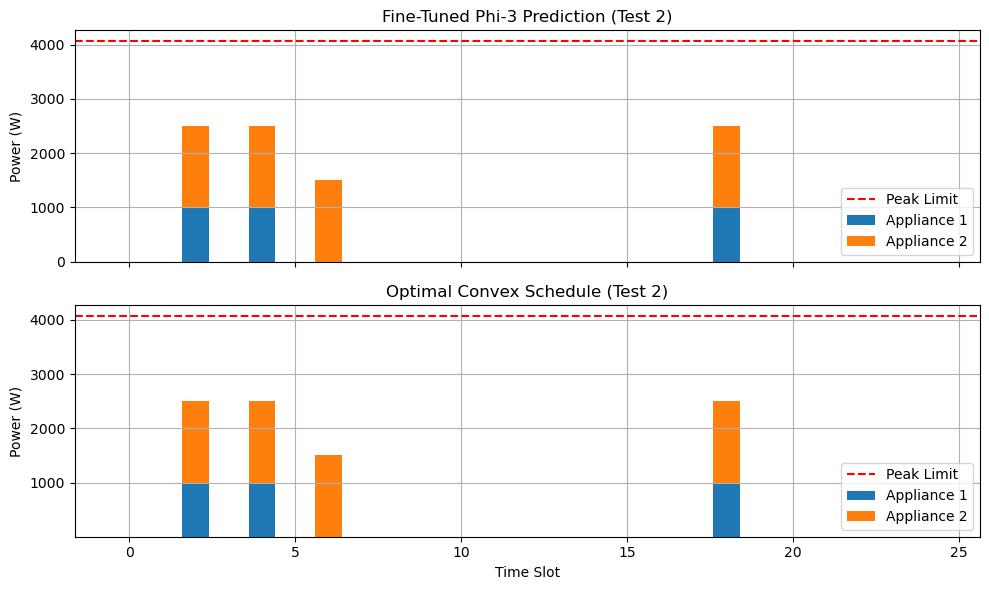

Test 2: Predicted Cost = $0.55 | Optimal Cost = $0.55 | Gap = $-0.00


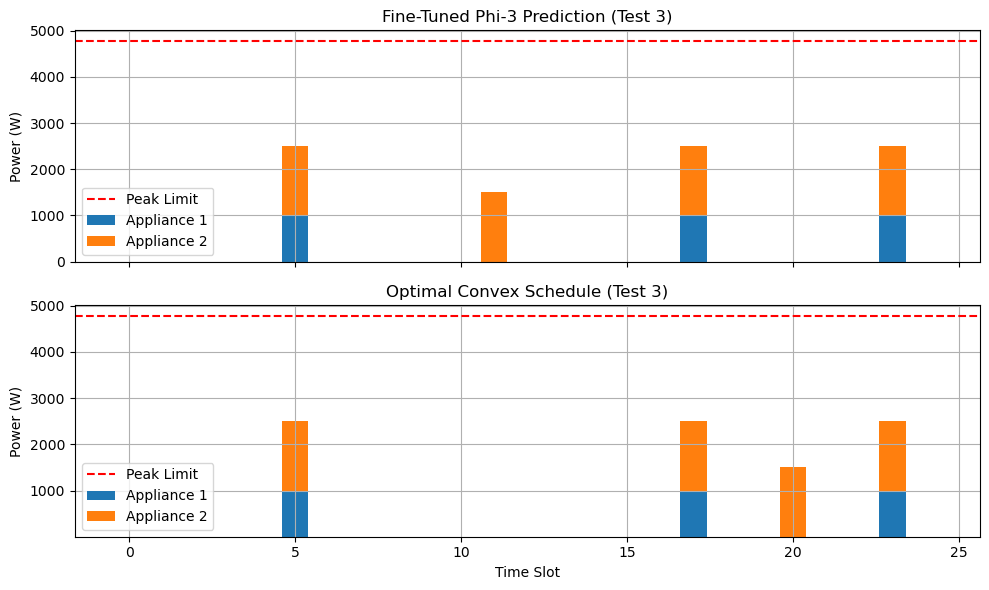

Test 3: Predicted Cost = $0.69 | Optimal Cost = $0.68 | Gap = $0.01


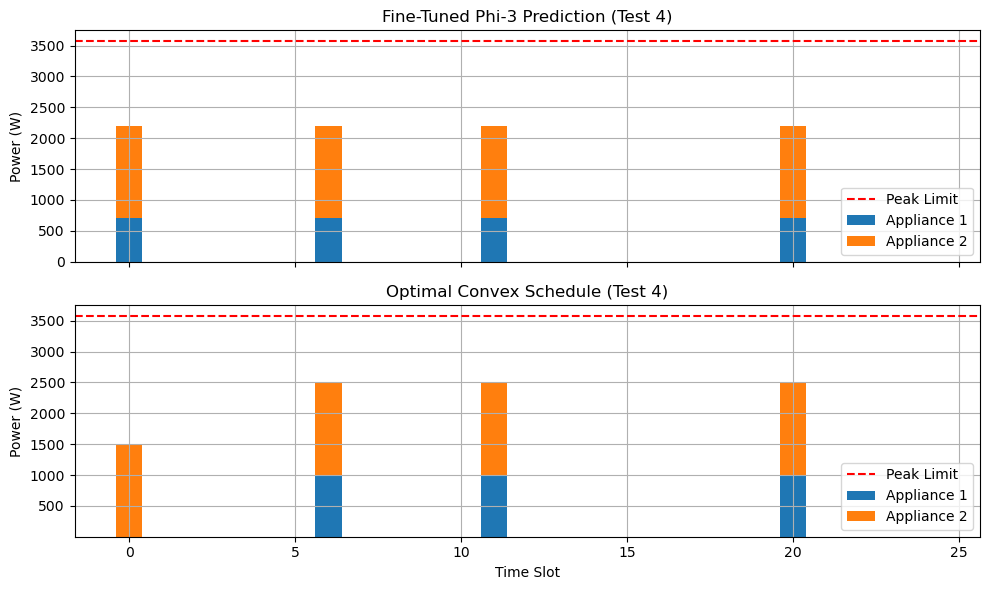

Test 4: Predicted Cost = $0.54 | Optimal Cost = $0.54 | Gap = $0.00


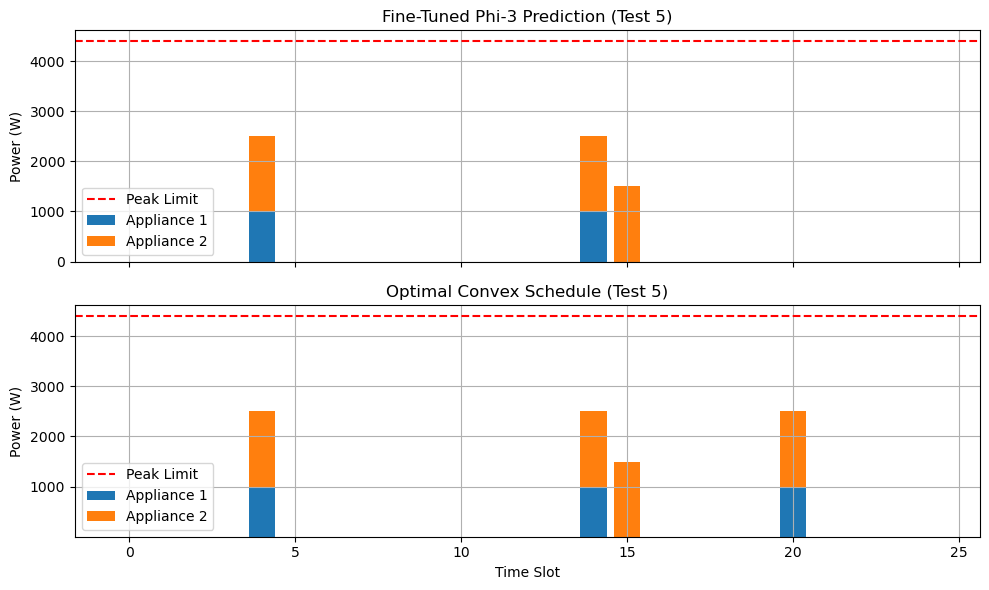

Test 5: Predicted Cost = $0.44 | Optimal Cost = $0.64 | Gap = $-0.20
Testing completed in 478.48 seconds.

Total script execution time: 7585.15 seconds
Which is approximately 126 minute(s) and 25.15 second(s).


In [2]:
# Install everything
!pip install transformers bitsandbytes peft torch cvxpy numpy matplotlib tabulate

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import re
from tabulate import tabulate

torch.cuda.empty_cache()

# 1) Convex Oracle
def generate_optimal_schedule(price, P_h, E_h, peak_limit):
    N, H = len(price), len(P_h)
    X = cp.Variable((N, H))
    power = cp.multiply(X, P_h.reshape(1, H))
    cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
    constraints = [
        cp.sum(power, axis=0) >= E_h,
        cp.sum(power, axis=1) <= peak_limit,
        X >= 0, X <= 1
    ]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=False)
    return X.value.astype(float)

# 2) Dataset
class TSLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N, H):
        self.prompts = []
        self.targets = []
        self.N, self.H = N, H
        self.P_h = np.array([1000, 1500])
        self.E_h = np.array([3000, 6000])
        self.peak_range = (2000, 6000)

        for _ in range(n_samples):
            price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
            peak_limit = np.random.randint(*self.peak_range)
            X_opt = generate_optimal_schedule(price, self.P_h, self.E_h, peak_limit)
            self.prompts.append(self._build_prompt(price, peak_limit))
            self.targets.append(torch.tensor(X_opt.flatten(), dtype=torch.float32))

    def _build_prompt(self, price, peak_limit):
        s = "[Prices]\n" + "\n".join(f"Slot {i+1}: {p:.3f} $/kWh" for i, p in enumerate(price))
        s += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(self.P_h, self.E_h), start=1):
            s += f"Appliance {i}:\n  Rated Power: {pw/1000:.1f} kW\n  Energy Required: {eg/1000:.1f} kWh\n"
        s += f"\n[Peak Limit]\n{peak_limit/1000:.1f} kW\n"
        s += "\n[Objective]\nMinimize total electricity cost.\n"
        s += f"\n[Output]\nProvide only a {self.N}x{self.H} matrix. Each row has two numbers (0-1) separated by comma, rows separated by semicolons."
        return s

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx], self.targets[idx]

# 3) Phi Model with LoRA
class PhiScheduler:
    def __init__(self, model_name="microsoft/Phi-3-mini-4k-instruct"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            quantization_config=bnb_config,
            trust_remote_code=True
        )

        model = prepare_model_for_kbit_training(model)

        lora_config = LoraConfig(
            r=8,
            lora_alpha=16,
            target_modules=["k_proj", "q_proj", "v_proj", "o_proj"],  # correct names for Phi-3
            lora_dropout=0.05,
            bias="none",
            task_type=TaskType.CAUSAL_LM,
        )

        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

        self.model = model
        self.model.eval()
        self.N = None
        self.H = None

    def fine_tune(self, dataset, epochs=1, batch_size=1, lr=2e-4):
        self.model.train()
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = AdamW(self.model.parameters(), lr=lr)
        loss_history = []

        for ep in range(1, epochs+1):
            running_loss = 0.0
            for prompts, targets in loader:
                full_texts = []
                for prompt, target in zip(prompts, targets):
                    schedule_text = ";".join(",".join(f"{v:.1f}" for v in target.reshape(self.N, self.H)[i]) for i in range(self.N))
                    full_prompt = prompt + "\n\n" + schedule_text
                    full_texts.append(full_prompt)

                encodings = self.tokenizer(full_texts, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
                outputs = self.model(**encodings, labels=encodings["input_ids"])
                loss = outputs.loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * len(prompts)

            avg_loss = running_loss / len(dataset)
            loss_history.append(avg_loss)
            print(f"Fine-tuning Epoch {ep}/{epochs} — Avg Loss: {avg_loss:.6f}")

        self.model.eval()

        # Plot Loss Curve
        plt.plot(range(1, epochs+1), loss_history, marker='o')
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Avg Loss')
        plt.grid(True)
        plt.show()

        return self

    def generate_schedule(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
        outputs = self.model.generate(**inputs, max_new_tokens=500, do_sample=False)
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

# 4) Parse output
def parse_phi_output(output, N, H):
    try:
        matrix_str = re.findall(r"(\d\.\d,\d\.\d;)", output)
        if not matrix_str or len(matrix_str) < N:
            raise ValueError("Not enough matrix rows parsed.")
        schedule = np.zeros((N, H))
        for i, entry in enumerate(matrix_str[:N]):
            values = entry.strip(';').split(',')
            schedule[i] = [float(v) for v in values]
        return np.clip(schedule, 0, 1)
    except Exception as e:
        print(f"Parsing error: {e}. Using zeros.")
        return np.zeros((N, H))

def test_and_plot(model, tests=5, N=25, H=2):
    import matplotlib.pyplot as plt
    import numpy as np
    import re

    P_h = np.array([1000, 1500])
    E_h = np.array([3000, 6000])

    tokenizer = model.tokenizer
    model = model.model
    model.eval()

    def parse_output(output, N, H):
        try:
            matrix_str = re.findall(r"(\d\.\d,\d\.\d;)", output)
            if not matrix_str or len(matrix_str) < N:
                raise ValueError("Not enough matrix rows parsed.")
            schedule = np.zeros((N, H))
            for i, entry in enumerate(matrix_str[:N]):
                values = entry.strip(';').split(',')
                schedule[i] = [float(v) for v in values]
            return np.clip(schedule, 0, 1)
        except Exception as e:
            print(f"Parsing error: {e}. Using zeros.")
            return np.zeros((N, H))

    for t_i in range(1, tests + 1):
        price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
        peak = np.random.randint(2000, 6000)

        # Build Prompt
        p = "[Prices]\n" + "\n".join(f"Slot {i+1}: {v:.3f} $/kWh" for i, v in enumerate(price))
        p += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(P_h, E_h), start=1):
            p += f"Appliance {i}:\n  Rated Power: {pw/1000:.1f} kW\n  Energy Required: {eg/1000:.1f} kWh\n"
        p += f"\n[Peak Limit]\n{peak/1000:.1f} kW\n"
        p += "\n[Objective]\nMinimize total electricity cost.\n"
        p += f"\n[Output]\nProvide only a {N}x{H} matrix."

        # Tokenize
        inputs = tokenizer(p, return_tensors="pt").to(model.device)

        # Fix for Phi-3 generation
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            use_cache=False,   # important fix
            do_sample=False
        )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Parse prediction
        pred_sched = parse_output(generated_text, N, H)

        # Solve optimal
        X = cp.Variable((N, H))
        power = cp.multiply(X, P_h.reshape(1, H))
        cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
        constraints = [
            cp.sum(power, axis=0) >= E_h,
            cp.sum(power, axis=1) <= peak,
            X >= 0, X <= 1
        ]
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve()
        opt_sched = X.value

        # Compute Costs
        cost_pred = (price[:, None] * (pred_sched * P_h) / 1000.0).sum()
        cost_opt = (price[:, None] * (opt_sched * P_h) / 1000.0).sum()

        # Plot
        t = np.arange(N)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)

        ax1.bar(t, pred_sched[:,0]*P_h[0], label="Appliance 1")
        ax1.bar(t, pred_sched[:,1]*P_h[1], bottom=pred_sched[:,0]*P_h[0], label="Appliance 2")
        ax1.axhline(peak, color='r', linestyle='--', label="Peak Limit")
        ax1.set_title(f"Fine-Tuned Phi-3 Prediction (Test {t_i})")
        ax1.set_ylabel("Power (W)")
        ax1.legend()
        ax1.grid(True)

        ax2.bar(t, opt_sched[:,0]*P_h[0], label="Appliance 1")
        ax2.bar(t, opt_sched[:,1]*P_h[1], bottom=opt_sched[:,0]*P_h[0], label="Appliance 2")
        ax2.axhline(peak, color='r', linestyle='--', label="Peak Limit")
        ax2.set_title(f"Optimal Convex Schedule (Test {t_i})")
        ax2.set_xlabel("Time Slot")
        ax2.set_ylabel("Power (W)")
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

        print(f"Test {t_i}: Predicted Cost = ${cost_pred:.2f} | Optimal Cost = ${cost_opt:.2f} | Gap = ${cost_pred-cost_opt:.2f}")


# 6) Main
#if __name__ == "__main__":
 #   N, H = 25, 2
  #  ds = TSLSupervisedDatasetStructured(300, N, H)  # Smaller dataset to fit memory
   # print("Loading Phi-3 with LoRA...")
  #  model = PhiScheduler()
   # model.N, model.H = N, H

#    print("Fine-tuning (LoRA)...")
 #   model = model.fine_tune(ds, epochs=5, batch_size=1, lr=2e-4)

  #  print("Testing...")
   # test_and_plot(model, tests=5, N=N, H=H)


import time # Import the time module at the top of your script

# ... (keep all your existing code: functions, classes, imports) ...

# 6) Main
if __name__ == "__main__":
    start_time = time.perf_counter() # Record the start time

    N, H = 25, 2
    print("Generating dataset...")
    ds_start_time = time.perf_counter()
    ds = TSLSupervisedDatasetStructured(300, N, H) # Smaller dataset to fit memory
    ds_end_time = time.perf_counter()
    print(f"Dataset generated in {ds_end_time - ds_start_time:.2f} seconds.")

    print("Loading Phi-3 with LoRA...")
    load_start_time = time.perf_counter()
    model = PhiScheduler()
    model.N, model.H = N, H
    load_end_time = time.perf_counter()
    print(f"Model loaded in {load_end_time - load_start_time:.2f} seconds.")

    print("Fine-tuning (LoRA)...")
    tune_start_time = time.perf_counter()
    # Make sure you've fixed the __init__ in PhiScheduler and __len__/__getitem__ in the dataset
    model = model.fine_tune(ds, epochs=30, batch_size=16, lr=2e-4)
    tune_end_time = time.perf_counter()
    print(f"Fine-tuning completed in {tune_end_time - tune_start_time:.2f} seconds.")

    print("Testing...")
    test_start_time = time.perf_counter()
    test_and_plot(model, tests=5, N=N, H=H)
    test_end_time = time.perf_counter()
    print(f"Testing completed in {test_end_time - test_start_time:.2f} seconds.")

    end_time = time.perf_counter() # Record the end time
    total_elapsed_time = end_time - start_time # Calculate the difference

    # Optional: Format the time for better readability
    minutes = int(total_elapsed_time // 60)
    seconds = total_elapsed_time % 60

    print("\n" + "="*30)
    print(f"Total script execution time: {total_elapsed_time:.2f} seconds")
    if minutes > 0:
        print(f"Which is approximately {minutes} minute(s) and {seconds:.2f} second(s).")
    print("="*30)